In [ ]:
#| default_exp markings

# markings
> module to work with both fan and blotch markings graphically

In [ ]:
#| export
import math
from math import cos, degrees, pi, radians, sin
from pathlib import Path

import matplotlib.lines as lines
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Ellipse
from numpy import arctan2
from numpy import linalg as LA
from shapely import affinity
from shapely import geometry as geom

from p4tools import io

In [ ]:
#| export
IMG_X_SIZE = 840

In [ ]:
#| export
IMG_Y_SIZE = 648

In [ ]:
#| export
def show_subframe(tile_id, ax=None, aspect="auto"):
    subframe = io.get_subframe_by_tile_id(tile_id)
    if ax is None:
        _, ax = plt.subplots(figsize=calc_fig_size(8))
    ax.imshow(subframe, origin="upper", aspect=aspect)
    ax.set_axis_off()
    return ax

In [ ]:
#| export
def set_subframe_size(ax):
    """Set plot view limit on Planet 4 subframe size."""
    ax.set_xlim(0, IMG_X_SIZE)
    ax.set_ylim(IMG_Y_SIZE, 0)

In [ ]:
#| export
def calc_fig_size(width):
    """Calc figure height in ratio of subframes."""
    ratio = IMG_X_SIZE / IMG_Y_SIZE
    return (width, width / ratio)

In [ ]:
#| export
# class Marking:
#     def __init__(self, data, scope="planet4"):
#         self.data = data
#         self.scope = scope

In [ ]:
#| export
class Blotch(Ellipse):

    """Blotch management class for P4.

    Parameters
    ----------
    data : object with blotch data attributes
        object should provide attributes [`x`, `y`, `radius_1`, `radius_2`, `angle`]
    scope : {'planet4', 'hirise'}
        string that decides between using x/y or image_x/image_y as center corods
    color : str, optional
        to control the color of the mpl.Ellipse object

    Attributes
    ----------
    to_average : list
        List of cols to be averaged after clustering
    data : object with blotch data attributes, as provided by `data`
    center : tuple (inherited from matplotlib.Ellipse)
        Coordinates of center, i.e. self.x, self.y
    """

    to_average = "x y image_x image_y angle radius_1 radius_2".split()

    @classmethod
    def from_tile_id(cls, tile_id, n=0, **kwargs):
        df = io.get_blotch_catalog()
        data = df[df.tile_id == tile_id].iloc[n]
        return cls(data, **kwargs)
        
    def __init__(self, data, scope="planet4", with_center=False, url_db="", **kwargs):
        self.data = data
        self.scope = scope if scope is not None else "planet4"
        self.with_center = with_center
        self.url_db = Path(url_db)
        self.ax = None
        if scope not in ["hirise", "planet4"]:
            raise TypeError("Unknown scope: {}".format(scope))
        try:
            self.x = data.x if scope == "planet4" else data.image_x
            self.y = data.y if scope == "planet4" else data.image_y
        except AttributeError:
            print("No x and y attributes in data:\n{}".format(data))
            raise AttributeError
        # default member number is 1. This is set to the cluster member inside
        # clustering execution.
        self._n_members = 1
        super(Blotch, self).__init__(
            (self.x, self.y),
            data.radius_1 * 2,
            data.radius_2 * 2,
            angle=data.angle,
            alpha=0.65,
            linewidth=2,
            fill=False,
            **kwargs
        )
        self.data = data

    @property
    def tile_id(self):
        return self.data.tile_id

    @property
    def subframe(self):
        return io.get_subframe_by_tile_id(self.data.tile_id)

    def show_subframe(self, ax=None, aspect="auto"):
        if ax is None:
            _, ax = plt.subplots(figsize=calc_fig_size(8))
        ax.imshow(self.subframe, origin="upper", aspect=aspect)
        ax.set_axis_off()
        self.ax = ax

    def is_equal(self, other):
        if (
            self.data.x == other.data.x
            and self.data.y == other.data.y
            and self.data.image_x == other.data.image_y
            and self.data.image_y == other.data.image_y
            and self.data.radius_1 == other.data.radius_1
            and self.data.radius_2 == other.data.radius_2
            and self.data.angle == other.data.angle
        ):
            return True
        else:
            return False

    def to_shapely(self):
        """Convert a markings.Blotch to shapely Ellipse.

        Code from https://gis.stackexchange.com/questions/243459/drawing-ellipse-with-shapely/243462
        """
        circ = geom.Point(self.center).buffer(1)
        ell = affinity.scale(circ, self.data.radius_1, self.data.radius_2)
        ellr = affinity.rotate(ell, self.data.angle)
        return ellr

    @property
    def area(self):
        return pi * self.data.radius_1 * self.data.radius_2

    @property
    def x1(self):
        return math.cos(math.radians(self.angle)) * self.data.radius_1

    @property
    def y1(self):
        return math.sin(self.angle) * self.data.radius_1

    @property
    def p1(self):
        return np.array(self.center) + np.array([self.x1, self.y1])

    @property
    def p2(self):
        return np.array(self.center) - np.array([self.x1, self.y1])

    @property
    def x2(self):
        return math.cos(math.radians(self.angle + 90)) * self.data.radius_2

    @property
    def y2(self):
        return math.sin(math.radians(self.angle + 90)) * self.data.radius_2

    @property
    def p3(self):
        return np.array(self.center) + np.array([self.x2, self.y2])

    @property
    def p4(self):
        return np.array(self.center) - np.array([self.x2, self.y2])

    @property
    def limit_points(self):
        return [self.p1, self.p2, self.p3, self.p4]

    def plot_center(self, ax, color="b"):
        ax.scatter(self.x, self.y, color=color, s=20, marker=".")

    def plot_limit_points(self, ax, color="b"):
        for x, y in self.limit_points:
            ax.scatter(x, y, color=color, s=20, marker="o")

    @property
    def n_members(self):
        return self._n_members

    @n_members.setter
    def n_members(self, value):
        self._n_members = value

    def plot(self, color="green", ax=None):
        if ax is None:
            _, ax = plt.subplots()
        self.show_subframe(ax)
        ax = self.ax
        if color is not None:
            self.set_color(color)
        ax.add_patch(self)
        if self.with_center:
            self.plot_center(ax, color=color)
        set_subframe_size(ax)

    def store(self, fpath=None):
        out = self.data
        for p in range(1, 5):
            attr = "p" + str(p)
            point = getattr(self, attr)
            out[attr + "_x"] = point[0]
            out[attr + "_y"] = point[1]
        if "image_id" not in out.index:
            pass
            # out['image_id'] = self.image_id
        if fpath is not None:
            out.to_hdf(str(fpath.with_suffix(".hdf")), "df")
        out["n_members"] = self.n_members
        return out

    def __str__(self):
        s = "markings.Blotch object. Input data:\n"
        s += self.data.__str__()
        s += "\n"
        s += "N_members: {}".format(self.n_members)
        return s

    def __repr__(self):
        return self.__str__()

In [ ]:
tile_with_blotches = 'APF0000004'

In [ ]:
b = Blotch.from_tile_id(tile_with_blotches)

100%|███████████████████████████████████████| 162k/162k [00:00<00:00, 67.7MB/s]


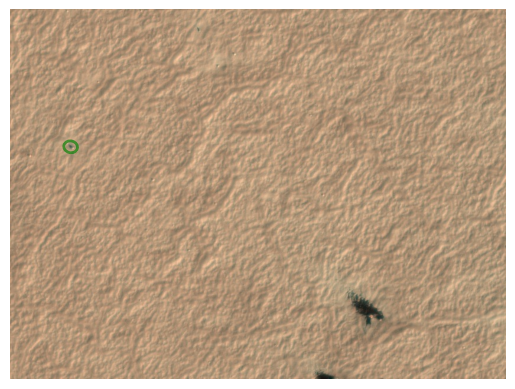

In [ ]:
b.plot()

In [ ]:
#| export
class TileBlotches:
    def __init__(self, tile_id, with_center=False, color='green'):
        """Container for all blotches of a tile.

        Parameters
        ----------
        tile_id :  str
            planetfour tile_id
        """
        self.tile_id = tile_id
        self.with_center = with_center
        self.blotches_df = io.get_blotches_for_tile(tile_id)
        self.collection = [
            Blotch(blotch, with_center=self.with_center, color=color)
            for _, blotch in self.blotches_df.iterrows()
        ]
        self.p = PatchCollection(self.collection, match_original=True)

    def plot(self, ax=None):
        if ax is None:
            _, ax = plt.subplots()
        ax = show_subframe(self.tile_id, ax=ax)
        ax.add_collection(self.p)
        set_subframe_size(ax)

In [ ]:
tb = TileBlotches(tile_with_blotches)

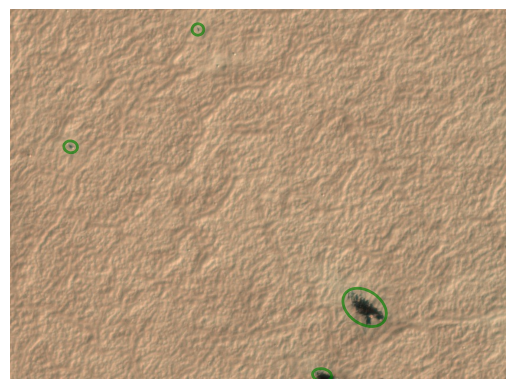

In [ ]:
tb.plot()

In [ ]:
#| export
def rotate_vector(v, angle):
    """Rotate vector by angle given in degrees.

    Parameters
    ----------
    v : np.array
        Vector to be rotated
    angle : float
        Angle in degrees
    """
    rangle = radians(angle)
    rotmat = np.array([[cos(rangle), -sin(rangle)], [sin(rangle), cos(rangle)]])
    return rotmat.dot(v)

In [ ]:
#| export
class Fan(lines.Line2D):
    """Fan management class for P4.

    Parameters
    ----------
    data : object with fan data attributes
        object has to provide [`x`, `y`, `angle`, `spread`, `distance`]
    scope : {'planet4', 'hirise'}
        string that decides between using x/y or image_x/image_y as base coords
    kwargs : dictionary, optional

    Attributes
    ----------
    to_average : list
        List of columns to average after clustering
    data : object with fan data attributes
        as provided by `data`.
    base : tuple
        base coordinates `x` and `y`.
    inside_half : float
        `data` divided by 2.0.
    armlength : float
        length of the fan arms.
    v1 : float[2]
        vector of first arm of fan.
    v2 : float[2]
        vector of second arm of fan.
    coords : float[3, 2]
        Set of coords to draw for MPL.Line2D object: arm1->base->arm2
    circle_base
    center
    radius
    midpoint
    base_to_midpoint_vec
    """

    to_average = "x y image_x image_y angle spread distance".split()

    @classmethod
    def from_tile_id(cls, tile_id, n=0, **kwargs):
        df = io.get_fan_catalog()
        data = df[df.tile_id==tile_id].iloc[n]
        return cls(data, **kwargs)
        
    def __init__(self, data, scope="planet4", with_center=False, **kwargs):
        self.data = data
        self.scope = scope if scope is not None else "planet4"
        self.with_center = with_center
        if scope not in ["hirise", "planet4"]:
            raise TypeError("Unknown scope: {}".format(scope))
        # first coordinate is the base of fan
        actual_x = "x" if scope == "planet4" else "image_x"
        actual_y = "y" if scope == "planet4" else "image_y"
        try:
            self.base = self.data.loc[[actual_x,
                                       actual_y]].values.astype("float")
        except KeyError:
            print("No x and y in the data:\n{}".format(data))
            raise KeyError
        # default n_members value (property)
        self._n_members = 1
        # angles
        self.inside_half = self.data.spread / 2.0
        alpha = self.data.angle - self.inside_half
        beta = self.data.angle + self.inside_half
        # length of arms
        self.armlength = self.get_arm_length()
        # first arm
        self.v1 = rotate_vector([self.armlength, 0], alpha)
        # second arm
        self.v2 = rotate_vector([self.armlength, 0], beta)
        # vector matrix, stows the 1D vectors row-wise
        self.coords = np.vstack(
            (self.base + self.v1, self.base, self.base + self.v2))
        # init fan line, first column are the x-components of the row-vectors
        lines.Line2D.__init__(self,
                              self.coords[:, 0],
                              self.coords[:, 1],
                              alpha=0.65,
                              color="white",
                              **kwargs)

    def is_equal(self, other):
        if (self.data.x == other.data.x and self.data.y == other.data.y and
                self.data.image_x == other.data.image_x and
                self.data.image_y == other.data.image_y and
                self.data.angle == other.data.angle and
                self.data.spread == other.data.spread and
                self.data.distance == other.data.distance):
            return True
        else:
            return False

    @property
    def tile_id(self):
        return self.data.tile_id

    @property
    def n_members(self):
        return self._n_members

    @n_members.setter
    def n_members(self, value):
        self._n_members = value

    def get_arm_length(self):
        half = radians(self.inside_half)
        return self.data.distance / (cos(half) + sin(half))

    @property
    def area(self):
        tr_h = np.sqrt(self.armlength**2 - self.radius**2)
        tr_area = tr_h * self.radius
        half_circ_area = 0.5 * pi * self.radius**2
        return tr_area + half_circ_area

    @property
    def circle_base(self):
        "float[2] : Vector between end of first arm and second arm of fan."
        return self.v1 - self.v2

    @property
    def semi_circle_center(self):
        """float[2] : vector from base to mid-point between end of arms.

        This is used for the drawing of the semi-circle at the end of the
        two fan arms.
        """
        return self.base + self.v2 + 0.5 * self.circle_base

    @property
    def radius(self):
        "float : for the semi-circle wedge drawing at the end of fan."
        return 0.5 * LA.norm(self.circle_base)

    def add_semicircle(self, ax, color="b"):
        "Draw a semi-circle at end of fan arms using MPL.Wedge."
        # reverse order of arguments for arctan2 input requirements
        theta1 = degrees(arctan2(*self.circle_base[::-1]))
        theta2 = theta1 + 180
        wedge = mpatches.Wedge(
            self.semi_circle_center,
            self.radius,
            theta1,
            theta2,
            width=0.01 * self.radius,
            color=color,
            alpha=0.65,
        )
        ax.add_patch(wedge)

    def add_mean_wind_pointer(self, ax, color="b", ls="-"):
        "Draw a thicker mean wind direction pointer for better visibility in plots."
        endpoint = rotate_vector([3 * self.armlength, 0], self.data.angle)
        coords = np.vstack((self.base, self.base + endpoint))
        self.wind_pointer_end = coords[1]
        pointer = lines.Line2D(coords[:, 0],
                               coords[:, 1],
                               alpha=0.65,
                               linewidth=1,
                               linestyle=ls)
        pointer.set_color(color)
        ax.add_line(pointer)

    def plot(self, color="green", ax=None):
        if ax is None:
            _, ax = plt.subplots()
        ax = show_subframe(self.tile_id, ax=ax)
        if color is not None:
            self.set_color(color)
        ax.add_line(self)
        self.add_semicircle(ax, color=color)
        if self.with_center:
            self.plot_center(ax, color=color)
        set_subframe_size(ax)

    # def plot(self, color="green", ax=None):
    #     self.show_subframe(ax)
    #     ax = self.ax
    #     if ax is None:
    #         _, ax = plt.subplots()
    #     if color is not None:
    #         self.set_color(color)
    #     ax.add_patch(self)
    #     if self.with_center:
    #         self.plot_center(ax, color=color)

    @property
    def center(self):
        """Calculate vector to half total length.

        As total length, I define the armlength + the radius of the semi-circle
        at the end.
        """
        mid_point_vec = rotate_vector([0.5 * (self.armlength + self.radius), 0],
                                      self.data.angle)
        return self.base + mid_point_vec

    def plot_center(self, ax, color="b"):
        ax.scatter(self.center[0],
                   self.center[1],
                   color=color,
                   s=20,
                   marker=".")

    @property
    def base_to_center_vec(self):
        coords = np.vstack((self.base, self.center))
        return coords

    def add_midpoint_pointer(self, ax, color="b", ls="-"):
        coords = self.base_to_center_vec
        pointer = lines.Line2D(coords[:, 0],
                               coords[:, 1],
                               alpha=0.65,
                               linewidth=3,
                               linestyle=ls)
        pointer.set_color(color)
        ax.add_line(pointer)

    def __str__(self):
        out = "markings.Fan object. Input data:\n"

        out += "base: {0}\narmlength: {1}\narm1: {2}\narm2: {3}".format(
            self.base, self.armlength, self.base + self.v1, self.base + self.v2)
        return out

    def __repr__(self):
        return self.__str__()

    def store(self, fpath=None):
        out = self.data
        for i, arm in enumerate([self.v1, self.v2]):
            out["arm{}_x".format(i + 1)] = (self.base + arm)[0]
            out["arm{}_y".format(i + 1)] = (self.base + arm)[1]
        if "image_id" not in out.index:
            # out['image_id'] = self.image_id
            raise AttributeError("Storage of image_id failed.")
        if fpath is not None:
            out.to_hdf(str(fpath.with_suffix(".hdf")), "df")
        out["n_members"] = self.n_members
        return out

    def to_shapely(self):
        """Create a shapely half circle rotated by the fan's angle.

        Notes
        =====
        `Motivated by: <https://stackoverflow.com/a/30762727/680232>`_
        """
        # Define the arc (presumably ezdxf uses a similar convention)
        centerx, centery = self.semi_circle_center

        # make a semi-circle first that points to the x-axis, rotate later.
        start_angle = 270  # In degrees

        # number of elements for the semi-circle
        numsegments = 100

        # The coordinates of the arc
        theta = np.radians(
            np.linspace(start_angle, start_angle + 180, numsegments))
        x = centerx + self.radius * np.cos(theta)
        y = centery + self.radius * np.sin(theta)

        arc = geom.LineString(np.column_stack([x, y]))

        rotated = affinity.rotate(arc,
                                  self.data.angle,
                                  origin=tuple(self.semi_circle_center))

        df = pd.DataFrame(np.vstack([self.coords[::-1][:2], np.array(rotated)]))
        return geom.Polygon(df.round(2).drop_duplicates().values)

In [ ]:
tile_with_fans = 'APF000000c'

In [ ]:
f = Fan.from_tile_id(tile_with_fans,1)

100%|█████████████████████████████████████| 9.94M/9.94M [00:00<00:00, 5.47GB/s]


100%|████████████████████████████████████████| 164k/164k [00:00<00:00, 119MB/s]


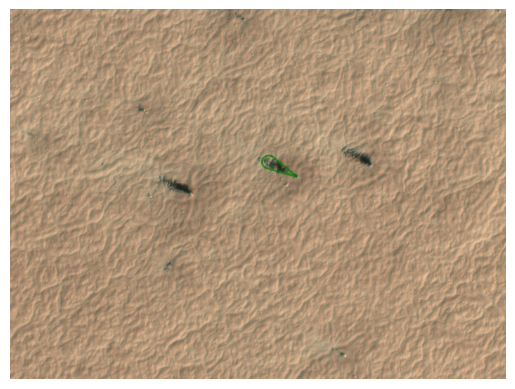

In [ ]:
f.plot()